In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys() :
  print('User Uploaded file "{name}" with length {length} bytes'.format(name = fn, length= len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:18<00:00, 69.0MB/s]
100% 1.33G/1.33G [00:18<00:00, 77.0MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/celeba-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from PIL import Image
from io import BytesIO
import base64
from IPython.core.display import display, HTML

In [ ]:
# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available.")
    # Additional information about the GPUs
    for gpu in gpu_available:
        print(tf.config.experimental.get_device_details(gpu))
else:
    print("GPU is not available.")

GPU is not available.


In [ ]:
BASIC_PATH = "/content/"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba/')
LIST_ATTR_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

DF_ATTR = pd.read_csv(BASIC_PATH + 'list_attr_celeba.csv', delimiter=',')
print(IMG_PATH, LIST_ATTR_PATH)
DF_ATTR.head()

/content/img_align_celeba/img_align_celeba/ /content/list_attr_celeba.csv


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
DF_PARTITION = pd.read_csv(BASIC_PATH + 'list_eval_partition.csv')


In [ ]:
DF_ATTR.set_index('image_id', inplace=True)
DF_ATTR.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
DF_ATTR.shape

(202599, 40)

In [ ]:
DF_PARTITION['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [ ]:
# join the partition with the attributes
DF_PARTITION.set_index('image_id', inplace=True)
DF_PARTITION = DF_PARTITION.join(DF_ATTR['Male'], how='inner')
DF_PARTITION.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
#ATTRIBUTES

# Read the attributes csv files in a dataframe format.
df = pd.read_csv(LIST_ATTR_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(-10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
...,...,...
2485,181963.jpg,Female
2486,156956.jpg,Female
2487,092708.jpg,Male
2488,039176.jpg,Female


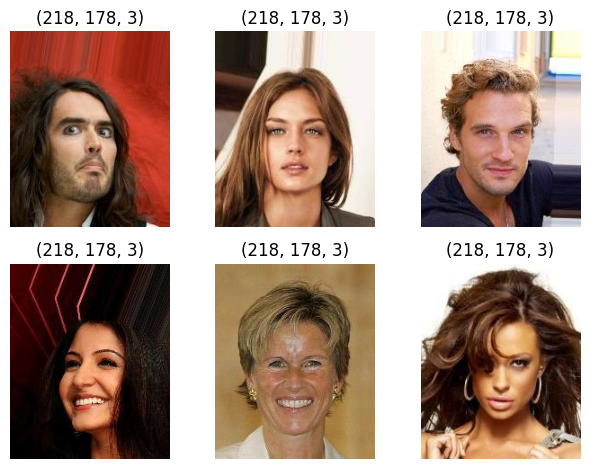

In [ ]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    1442
Male      1058
Name: Gender, dtype: int64


In [ ]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

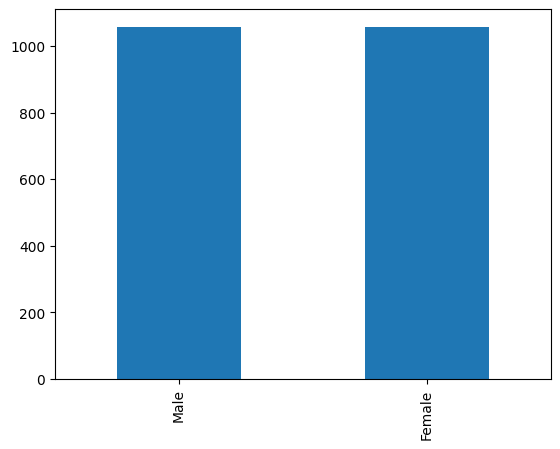

In [ ]:
df["Gender"].value_counts().plot.bar()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [ ]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1692
Total Test Sample Images :  284
Total Validation Sample Images :  140


In [ ]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 15



In [ ]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1692 validated image filenames belonging to 2 classes.


In [ ]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 140 validated image filenames belonging to 2 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 284 validated image filenames.


GAPERLU

In [ ]:
# train_dataset = tf.data.Dataset.from_generator(lambda:train_generator,
#                                                output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
#                                                                 tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))

# validation_dataset = tf.data.Dataset.from_generator(lambda:validation_generator,
#                                                output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
#                                                                 tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))


# test_dataset = tf.data.Dataset.from_generator(lambda:test_generator,
#                                                output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
#                                                                 tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))



In [ ]:
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
base_vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))

In [ ]:
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

BASE MODEL

In [ ]:
vgg_model = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

In [ ]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1

In [ ]:
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
history = vgg_model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7573

112/112 [==============================] - 1103s 10s/step - loss: 0.4926 - accuracy: 0.7573 - val_loss: 0.3151 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8456

112/112 [==============================] - 1076s 10s/step - loss: 0.3472 - accuracy: 0.8456 - val_loss: 0.3407 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.8599

112/112 [==============================] - 1058s 9s/step - loss: 0.3277 - accuracy: 0.8599 - val_loss: 0.3569 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8927

112/112 [==============================] - 1046s 9s/step - loss: 0.2754 - accuracy: 0.8927 - val_loss: 0.3075 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8837

112/112 [==============================] - 1052s 9s/step - loss: 0.2650 - accuracy: 0.8837 - val_loss: 0.3080 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8909

112/112 [==============================] - 1052s 9s/step - loss: 0.2586 - accuracy: 0.8909 - val_loss: 0.2786 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8927

112/112 [==============================] - 1047s 9s/step - loss: 0.2594 - accuracy: 0.8927 - val_loss: 0.3117 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9088

112/112 [==============================] - 1046s 9s/step - loss: 0.2430 - accuracy: 0.9088 - val_loss: 0.2584 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9207

112/112 [==============================] - 1052s 9s/step - loss: 0.2090 - accuracy: 0.9207 - val_loss: 0.2864 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9141

112/112 [==============================] - 1055s 9s/step - loss: 0.2039 - accuracy: 0.9141 - val_loss: 0.3464 - val_accuracy: 0.8815 - lr: 0.0010


In [ ]:
vgg_model.save("model.h5")

In [ ]:
vgg_model = tf.keras.models.load_model("/content/model.h5")

In [ ]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
vgg_model.evaluate(test_generator)

19/19 [==============================] - 1s 59ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
predict = vgg_model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

19/19 [==============================] - 115s 6s/step


In [ ]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [ ]:
test_df

,image_id,Gender,Prediction
119,071160.jpg,Female,Female
2406,162337.jpg,Female,Female
914,060475.jpg,Male,Male
1230,102227.jpg,Male,Male
976,148106.jpg,Male,Male
...,...,...,...
1461,107642.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Female
2334,140047.jpg,Male,Male


In [ ]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[119,  17],
       [  7, 141]])

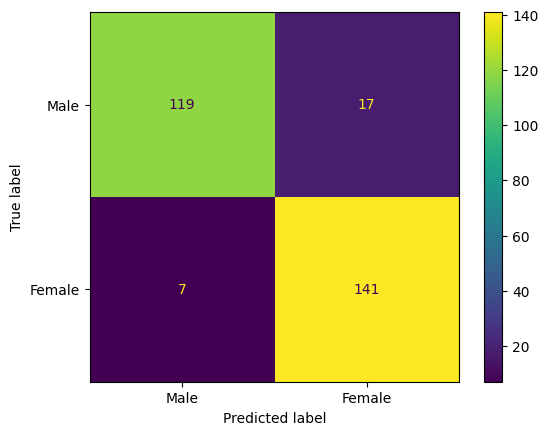

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

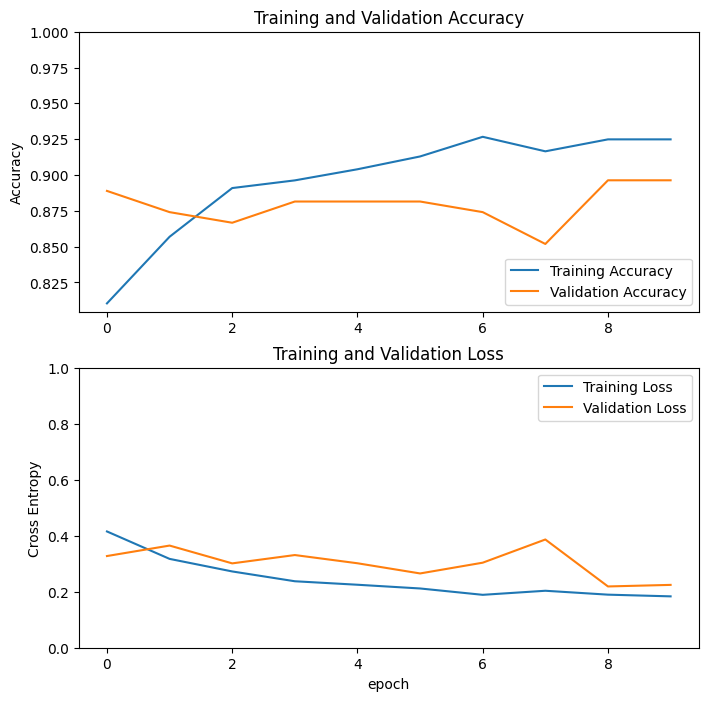

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_generator, steps=len(test_generator))
print('test acc:', test_acc)
print('test_loss:', test_loss)


19/19 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
test acc: 0.0
test_loss: 0.0


In [ ]:
base_vgg_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_vgg_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_vgg_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [ ]:
base_learning_rate = 0.0001

vgg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
gender_target = {0: 'Female', 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)

    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)

    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def display_result(filename, prediction, target):
    '''
    Display the results in HTML

    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"

    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'

    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3> <br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p> <br><br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               ,  gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [ ]:
def gender_prediction(filename):
    '''
    predict the gender

    input:
        filename: str of the file name

    return:
        array of the prob of the targets.

    '''

    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    # prediction
    result = vgg_model.predict(im)
    prediction = np.argmax(result)

    return result

1/1 [==============================] - 0s 394ms/step



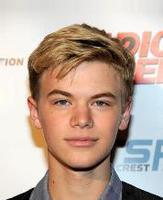

1/1 [==============================] - 0s 387ms/step



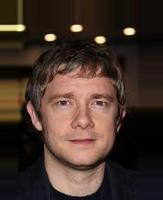

1/1 [==============================] - 0s 377ms/step



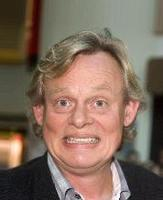

1/1 [==============================] - 0s 377ms/step



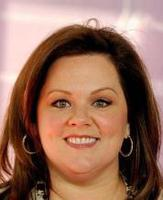

1/1 [==============================] - 0s 385ms/step



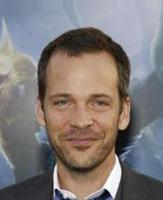

1/1 [==============================] - 0s 383ms/step



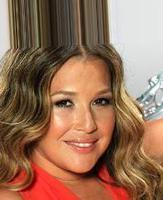

1/1 [==============================] - 0s 375ms/step



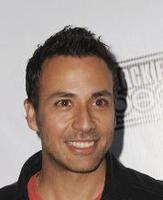

1/1 [==============================] - 0s 386ms/step



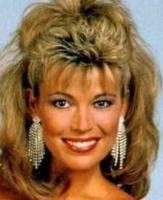

In [ ]:
df_to_test = DF_PARTITION[(DF_PARTITION['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(IMG_PATH + index)

    #display result
    display_result(IMG_PATH + index, result[0], target['Male'])